In [1]:
# Sorta like jpeg 2000

In [1]:
# Import functions and libraries
%pylab
import numpy as np
import matplotlib.pyplot as plt
import pyaudio, Queue, threading,time, sys, threading,time, serial
from __future__ import division
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr
from scipy import misc
import cPickle as pickle
import operator

import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

import pywt

# import ax25
import bitarray, time, urllib, ssl

# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('picked_name.pickle', 'rb')
# Y = pickle.load(f)
# f.close()

%matplotlib inline
# %pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['figure.figsize'] = (8, 6) # (16, 16) # (6, 4) for normal size

## TODO

In [3]:
    # dealing with color images: chroma subsampling, YCrCb
    
    # chroma subsampling
    
    # encoding of zigzagged block
                            
    # transmit encoded blocks

## END TODO

In [4]:
# Compression functions

def compress_bw(im, fraction_coeffs, step_size, wvlt='db4', level=1):
    # step_size: quantization step size
    
    # DC Level Shift
    im, bit_depth = subtract_bit_depth(im)
    
    # Compute dwt2
    dwt = dwt2(im, level, wvlt)
    
    # Threshhold wavelet coefficients
    if fraction_coeffs != 1:
        thresh = thresh_dwt(dwt, f=fraction_coeffs)
    
    # Quantize coeffs (these can be transmitted to reconsxt image later)
    thresh = scalar_quantizer(thresh, step_size)

    return np.int8(thresh), bit_depth
    
def decompress_bw(threshed_dwt, original_shape, original_bit_depth, step_size, delta=0.5, wvlt='db4', level=1):
    # inverse of the above compression function.
    
    threshed_dwt = scalar_dequantizer(threshed_dwt, step_size=step_size, delta=delta)
    
    # if original_bit_depth = 8 (ie 0-255 values), then add 2**7 because we sub'd 2**7 before.
    
    compressed_img = idwt2(threshed_dwt, wvlt=wvlt, levels=level) + 2**(original_bit_depth-1)
    
    return compressed_img

In [5]:
# Utility functions

def rgb2gray(img):
    # converts RGB img into 1 channel
    # mainly for testing
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def num_nonoverlap_tiles(shape, tile_size):
    # shape: image shape, (rows, cols), rows and cols both must be at least tile_size**2.
    # tile_size: number of pixels in an edge of a tile. must be power of 2.
    # returns: num tiles that fit image with shape shape without overlap
    assert log(tile_size)/log(2) % 1 == 0, 'Tile size must be a power of 2.'
    rows, cols = shape
    assert rows >= tile_size and cols >= tile_size, 'Tile size too large.'
    horiz = rows//tile_size
    vert = cols//tile_size
    return horiz, vert

def subtract_bit_depth(image):
    # Level shift: (helps with getting chains of zeros in DWT)
    bit_depth = log(image.max()-1)/log(2)//1 + 1
    image = image - 2**(bit_depth-1)
    return image, bit_depth

def bit_depth_to_add(image):
    bit_depth = log(image.max()-1)/log(2)//1
    return bit_depth

def bit_depth(image):
    bit_depth = log(abs(image).max())/log(2)//1 + 1
    if image.min() < 0:
        bit_depth += 1
    return int(bit_depth)

def get_multiple_shape(shape, tile_size):
    # finds the shape where each dimension is a multiple of tile_size
    horiz_tiles = shape[0]//tile_size
    if horiz_tiles*tile_size != shape[0]:
        # we add a tile to this dim so tiles fit w/out overlap
        horiz_tiles += 1

    vert_tiles = shape[1]//tile_size
    if vert_tiles*tile_size != shape[1]:
        vert_tiles += 1

    new_shape = (horiz_tiles*tile_size, vert_tiles*tile_size)
    return new_shape

def map2multiple(image, tile_size):
    # map the original image so dims are a multiple of tile_size.
    horiz, vert = get_multiple_shape(image.shape, tile_size)
    new_image = np.zeros((horiz, vert))
    new_image[:image.shape[0],:image.shape[1]] = image
    return new_image

def map2original(image, shape):
    # map back to the original image.
    # inverse of map_overlap...
    original = np.zeros(shape)
    original = image[:shape[0],:shape[1]]
    return original

def image2tile_partition(image, tile_size):
    # image must already be mapped 2 multiple.
    # returns list of tiles
    # scans left to right, top to bot.
    tiles = []
    for i in range(int(image.shape[0]/tile_size)):
        for j in range(int(image.shape[1]/tile_size)):
            tiles += [image[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]]
    return np.array(tiles)

def tile_partition2image(tiles, tiles_per_row, tile_size):

    # Calculate tiles per column
    tiles_per_column = int(tiles.shape[0]/tiles_per_row + 1*((tiles.shape[0]%tiles_per_row)!=0))

    # Reshaping tiles
    tiles = tiles.reshape(tiles.shape[0],tile_size,tile_size)

    # Untiling Loop
    tiled = []
    for i in range(0,tiles_per_column*tiles_per_row,tiles_per_row):
        tiled.append(hstack(tiles[i:i+tiles_per_row,:,:]))

    return vstack(tiled)

def dwt_tiles(tiles, wvlt='db4', level=1):
    # single level db4 wt on each tile.
    dwts = []
    for tile in tiles:
        dwts += [dwt2(tile, wvlt=wvlt, level=level)]
    return np.array(dwts)

def thresh_dwt(dwt_tiles, f):
    # f: the fraction f largest wavelet coeffs (to save)
    # parts borrowed from hw9
    # used with the output of dwt_tiles(...)
    m = np.sort(abs(dwt_tiles.ravel()))[::-1]
    idx = int(len(m) * f) # the fraction f largest wavelet coeff.
    thr = m[idx] # threshhold
    return dwt_tiles * (abs(dwt_tiles) > thr)
#     thresh_tiles = dwt_tiles * (abs(dwt_tiles) > thr)
#     return np.array(thresh_tiles)

# def thresh_dwt(dwt_tiles, f):
#     # f: the fraction f largest wavelet coeffs (to save)
#     # parts borrowed from hw9
#     # used with the output of dwt_tiles(...)
#     thresh_tiles = []
#     for tile in dwt_tiles:
#         m = np.sort(abs(tile.ravel()))[::-1]
#         idx = int(len(m) * f) # the fraction f largest wavelet coeff.
#         thr = m[idx] # threshhold
#         thresh_tiles += [tile * (abs(tile) > thr)]
#     return np.array(thresh_tiles)

def tile_idwt(tiles, wvlt='db4', level=1):
    idwts = []
    for tile in tiles:
        idwts += [idwt2(tile, wvlt=wvlt, levels=level)]
    return np.array(idwts)

def show_dwt_tiles(image, tile_size, im_title='DWT tiles', wvlt='db4'):
    # used for showing dwt tiles of original, uncompressed images. 
    tiles = dwt_tiles(image2tile_partition(map2multiple(subtract_bit_depth(image)[0], tile_size), tile_size), wvlt=wvlt)
    figure()
    title(im_title)
    mult_shape = get_multiple_shape(image.shape, tile_size)
    imshow(tile_partition2image(tiles, mult_shape), cmap = 'gray')
    return tiles

# img2coeffs
def scalar_quantizer(data, step_size):
    return np.sign(data)*(abs(data)//step_size)

def scalar_dequantizer(coeffs, step_size, delta=0.5):
    # delta: a user-selectable parameter. 0 <= delta < 1.
    return np.sign(coeffs)*(abs(coeffs) + delta)*step_size

def PSNR(im1, im2):
    # bw imgs
    return 10*np.log10(2**64/(np.sum((im1 - im2)**2)))

def compare_imgs(original, compressed):
    figure()
    title('Comparison: left original, right compressed')
    imshow(np.concatenate((original, compressed), axis=1), cmap = 'gray')
    
def zigzag(n):
    # returns the order of zigzag traversal of a square nxn matrix
    # borrowed code from http://paddy3118.blogspot.com/2008/08/zig-zag.html
    # and from http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
    def sortbyvalue(x):
        return np.array(sorted(x.items(), key=operator.itemgetter(1)))[:,0]
    indexorder = sorted(((x,y) for x in range(n) for y in range(n)),\
                        key = lambda p: (p[0]+p[1], -p[1] if (p[0]+p[1]) % 2 else p[1]) ) 
    return sortbyvalue(dict((index,n) for n,index in enumerate(indexorder)))

In [6]:
# Transmission and encoding code

In [7]:
# def array2code_blocks(array, code_block_size=16):
#     # We will do processing on code blocks, and encode code blocks and send them specially (entropy enocding)
#     # code_block_size is a power of 2
#     # code blocks are sections of the wavelet domain
#     return np.uint8(np.vstack(image2tile_partition(array, code_block_size)))

# def code_blocks2array(code_blocks, original_shape, block_size):
#     # num_tiles is the number of tiles you divided your original image into in the spatial domain.
#     code_blocks = np.int8(code_blocks)
#     r,c = get_multiple_shape(original_shape, tile_size)
#     vert_tiles, horiz_tiles = int(r/tile_size), int(c/tile_size)
#     block_size = code_blocks.shape[2]
#     num_tiles = vert_tiles*horiz_tiles
#     tiles = []
#     for t in range(num_tiles):
#         tile = []
#         for cb in code_blocks[t*len(code_blocks)//num_tiles:(t+1)*len(code_blocks)//num_tiles]:
#             tile += [cb]
#         tiles += [tile_partition2image(np.array(tile), int(tile_size/block_size), block_size)]
#     return np.array(tiles)

def int2bitarray(intarray, width=8):
    # converts an array of integers type uint8 and returns an equivalent Python bitarray.bitarray
    # use width = 1 if intarray contains 1, 0s
    # use width = 8 for 8 bit ints
    bits = ''
    for num in intarray:
        bits += np.binary_repr(num,width)
    return bitarray.bitarray(bits)

def encode_block(block, width):
    #todo: actual encoding.
    array_of_bits = []
    for row in block:
        array_of_bits += [int2bitarray(row,width)]
    return array_of_bits

def decode_block(block):
    #todo
    return

def block_to_zigzag(block):
    # flattens a square block to its zigzag traversal
    inds = zigzag(block.shape[0])
    zz = []
    for ind in inds:
        zz += [block[ind]]
    return zz

def zigzag_to_block(zz):
    # the inverse of the above
    inds = zigzag(int(np.sqrt(len(zz))))
    block = np.zeros((int(np.sqrt(len(zz))),int(np.sqrt(len(zz)))))
    for i in range(len(zz)):
        block[inds[i]] = zz[i]
    return block

In [8]:
# Resources: HW9, 
#            http://faculty.gvsu.edu/aboufade/web/wavelets/student_work/ef/how-works.html,
#            http://www.dmi.unict.it/~battiato/EI_MOBILE0708/JPEG2000%20(Bruna).pdf
#            http://library.msri.org/books/Book46/files/08li.pdf

In [9]:
# This cell contains functions borrowed from hw9.

def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res

def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))

def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
def dwt2(im, level=1, wvlt='db4'):
    coeffs = pywt.wavedec2(im, wavelet=wvlt, mode='per', level=level)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim

def idwt2(Wim, levels=1, wvlt='db4'):
    coeffs = img2coeffs(Wim, levels=levels)
    return pywt.waverec2(coeffs, wavelet=wvlt, mode='per')

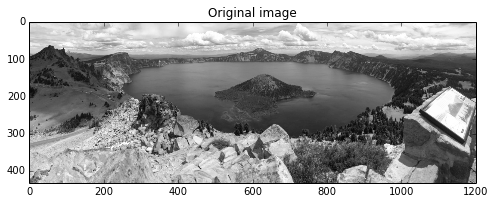

In [51]:
image = misc.imread('imgs/lake.bmp') # load an image: {dude, cal, lake,...}

# plt.imshow(image)
# plt.title('Show color image')

im = rgb2gray(image) # convert to grayscale
original = np.copy(im)

title('Original image')
imshow(original, cmap = 'gray')

In [97]:
num_levels = 3
fraction_coeffs = .03
stepsize = 2**6
_delta = 0.6
wavelet = 'bior2.2' # http://wavelets.pybytes.com/wavelet/bior4.4/
dwt2im, orig_bit_depth = compress_bw(im, fraction_coeffs, step_size=stepsize, wvlt=wavelet, level=num_levels)
compressed_img = decompress_bw(dwt2im, im.shape, orig_bit_depth, step_size=stepsize, delta=_delta, wvlt=wavelet, level=num_levels)
# cefs = img2coeffs(dwt2im, num_levels)
print(abs(dwt2im).max())

20


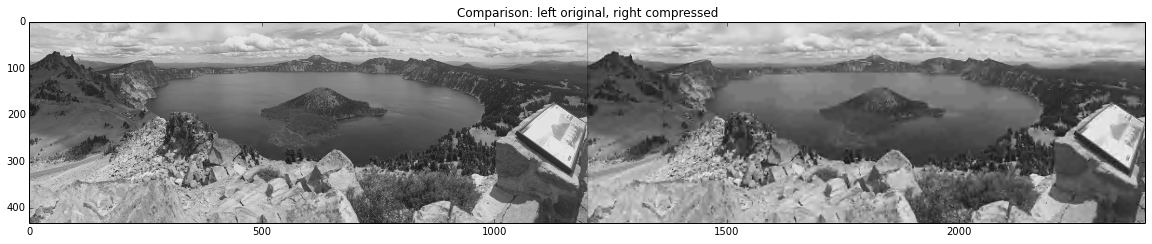

In [98]:
plt.rcParams['figure.figsize'] = (20, 20) # (6, 4) for normal size
compare_imgs(original, compressed_img)
plt.rcParams['figure.figsize'] = (8, 6)

('PSNR:', 114.99920409418132)


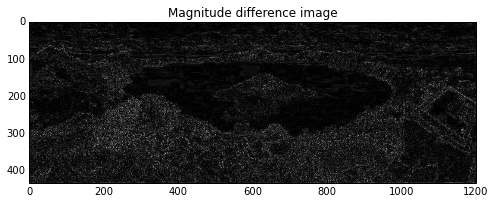

In [99]:
title('Magnitude difference image')
imshow(abs(compressed_img - original), cmap = 'gray')
print('PSNR:',PSNR(compressed_img, im))

In [58]:
# to_encode = array2code_blocks(dwt2im, code_block_size=16)
# print(to_encode.shape)
# recvd = code_blocks2array(to_encode, im.shape, 16)
# print('difference',np.sum(tiles!=recvd))
# a_block = to_encode[0]
# print(a_block.shape)
# azz == zigzag_to_block(block_to_zigzag(a_block))

In [18]:
# todo: encoding of zigzagged result

In [19]:
# in jpeg 2000, we still can divide the image into tiles, but they should be pretty large, so that we can build multi-level
# wavelet pyramids, and avoiding blocking effects in regular jpeg from having many tiles and coding errors (lossy).

In [753]:

# def max_decomp_level(shape, wvlt='bior4.4'):
#     # returns the maximum useful level of decomposition for the given input data shape and wavelet.
#     wv = pywt.Wavelet(wvlt)
#     return pywt.dwt_max_level(data_len=np.min(shape), filter_len=wv.dec_len)

In [752]:
# def format_coeffs_for_thresh(coeffs):
#     # convert output of dwt2 to array without tuples
#     retval = [coeffs[0]]
#     i = 1
#     while i <= len(coeffs) - 3:
#         retval += [np.array([coeffs[i], coeffs[i+1], coeffs[i+2]])]
#         i+=3
#     return retval

# def format_coeffs_for_idwt2(coeffs):
#     # convert output of dwt2 to list
#     list_coeffs = [coeffs[0].tolist()]
#     i = 1
#     while i <= len(coeffs) - 3:
#         list_coeffs += [(coeffs[i], coeffs[i+1], coeffs[i+2])]
#         i+=3
#     return list_coeffs

In [12]:
# def coeffs2img(coeffs):
#     # creates image from a multi-level dwt with most non-square coeffs!
#     # the shapes all must end up matching, however, and for higher levels, this may not work.
#     if len(list(coeffs)) == 2:
#         return np.vstack([np.hstack([coeffs[0], coeffs[1][0]]), np.hstack([coeffs[1][1], coeffs[1][2]])])
        
#     else:
#         return np.vstack([np.hstack([coeffs2img(coeffs[:-1]), coeffs[-1][0]]), np.hstack([coeffs[-1][1], coeffs[-1][2]])])

# def img2coeffs(im, levels):
#     coeffs = []
#     for i in range(levels):
#         r,c = im.shape
#         H = im[:int(r/2),int(c/2):]
#         V = im[int(r/2):,:int(c/2)]
#         D = im[int(r/2):,int(c/2):]
#         im = im[:int(r/2),:int(c/2)]
#         coeffs.insert(0, (H, V, D))            
#     coeffs.insert(0,im)
#     return coeffs